<a href="https://colab.research.google.com/github/ronaldsholt/ML_Vandy/blob/main/Ron_Holt_ML_Project_Idea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Background**: Predicting cell lineage patterns in RNAseq measurments.

**Project Description**: Using representation learning as low dimentional input to higher dimentional reduction clustering tools like TSNE or UMAP to learn cell lineage. Also evaluate against traditional methods like PCA or Logistic PCA.

**Performance Metric**: Min{L2-norm/MSE}

#Basic EDA

In [ ]:
#Basic EDA Questions

#1. How many variations are there?
#2. What is the highest sequence variation ?
#3. What is the highest gene-gene correlation ?
#4. What is the class break down?

UsageError: Line magic function `%md` not found.


In [3]:
# Calling and assigning GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

# import the data from drive
path = "/content/drive/My Drive/rna_proj/data/scaled_all_specific_exp/mat.norm.scale.2000.csv" 
df = pd.read_csv(path)
df = df.drop(["Unnamed: 0"], axis = 1) 

In [6]:
path_1 = "/content/drive/My Drive/rna_proj/data/variable.features.csv"
df_feat = pd.read_csv(path_1)

In [7]:
# index the columns based on 2000 features 
lst = list(df_feat["x"])
lst.append("Variable") #add back the RNA seq

# index df to select only these columns using intersect
df_new = df[df.columns.intersection(lst)]

In [8]:
df_new.head()

,Variable,Sox17,Prex2,Terf1,Mcm3,Khdrbs2,Prim2,Bag2,Ptpn18,Hs6st1,...,Nolc1,Nfkb2,Gsto1,Add3,Mxi1,Dusp5,Gm16299,Pdcd4,Plekhs1,Shtn1
0,AAACCCAGTTCCACAA,-1.393788,-0.400318,1.358433,-0.494224,-0.084449,0.199815,-0.490080,-0.298271,-0.493740,...,0.447022,0.738963,1.262297,-0.410792,1.378466,-0.422791,-0.043317,-0.170391,-0.078911,-0.195295
1,AAACCCATCACGAACT,-0.582664,-1.409803,0.177138,1.502572,-0.084449,0.554011,1.077822,1.039509,0.734416,...,0.125040,-0.603773,-0.720412,-0.980596,0.055242,-0.422791,-0.043317,-0.641089,-0.078911,-0.195295
2,AAACGAAAGCCGAATG,-0.146528,-0.251669,-0.801586,-0.310414,-0.084449,1.765205,-0.490080,-0.186529,-0.493740,...,0.318736,-0.603773,0.582429,-0.028609,-0.250889,0.645672,-0.043317,-0.641089,-0.078911,-0.195295
3,AAACGAAGTTCAAAGA,1.102187,-0.634825,1.040665,-0.772438,-0.084449,2.116643,0.681951,-0.487508,-0.493740,...,-0.638577,-0.603773,-0.720412,0.131617,0.788557,-0.422791,-0.043317,-0.136620,-0.078911,-0.195295
4,AAACGAATCCGACGGT,0.863034,0.133187,0.329966,-0.557825,-0.084449,-0.616780,-0.490080,1.091608,-0.493740,...,-1.194605,-0.603773,-0.720412,1.233833,-0.775900,1.532813,-0.043317,1.188186,-0.078911,-0.195295


In [9]:
# Import labels, and join on Variable barcode 
# Import the 2001 cell labels
path_3 = "/content/drive/My Drive/rna_proj/data/cell.types.2001.csv"
df_labels = pd.read_csv(path_3)
df_labels = df_labels.rename(columns={"Unnamed: 0": "Variable"})
df_labeled = pd.merge(df_labels, df_new, on="Variable")

In [10]:
df_new = df_labeled #rename
df_new.head()

,Variable,cell.type,Sox17,Prex2,Terf1,Mcm3,Khdrbs2,Prim2,Bag2,Ptpn18,...,Nolc1,Nfkb2,Gsto1,Add3,Mxi1,Dusp5,Gm16299,Pdcd4,Plekhs1,Shtn1
0,AAACCCAGTTCCACAA,cycling_capillary,-1.393788,-0.400318,1.358433,-0.494224,-0.084449,0.199815,-0.490080,-0.298271,...,0.447022,0.738963,1.262297,-0.410792,1.378466,-0.422791,-0.043317,-0.170391,-0.078911,-0.195295
1,AAACCCATCACGAACT,artery_1,-0.582664,-1.409803,0.177138,1.502572,-0.084449,0.554011,1.077822,1.039509,...,0.125040,-0.603773,-0.720412,-0.980596,0.055242,-0.422791,-0.043317,-0.641089,-0.078911,-0.195295
2,AAACGAAAGCCGAATG,cycling_capillary,-0.146528,-0.251669,-0.801586,-0.310414,-0.084449,1.765205,-0.490080,-0.186529,...,0.318736,-0.603773,0.582429,-0.028609,-0.250889,0.645672,-0.043317,-0.641089,-0.078911,-0.195295
3,AAACGAAGTTCAAAGA,cycling_capillary,1.102187,-0.634825,1.040665,-0.772438,-0.084449,2.116643,0.681951,-0.487508,...,-0.638577,-0.603773,-0.720412,0.131617,0.788557,-0.422791,-0.043317,-0.136620,-0.078911,-0.195295
4,AAACGAATCCGACGGT,artery_2,0.863034,0.133187,0.329966,-0.557825,-0.084449,-0.616780,-0.490080,1.091608,...,-1.194605,-0.603773,-0.720412,1.233833,-0.775900,1.532813,-0.043317,1.188186,-0.078911,-0.195295


# EDA Questions

In [ ]:
#1. How many variations are there?

df_new["Variable"].nunique()

1981

In [ ]:
#2. What is the highest sequence variation ?

In [ ]:
df_new["Variable"].value_counts(sort=True, ascending=False).head() # check if all unique

AAACCCAGTTCCACAA    1
GTCTCACTCTGGTGCG    1
GTCTAGACATCGGAAG    1
GTCTAGACATACAGGG    1
GTCTACCCAGGTCAAG    1
Name: Variable, dtype: int64

In [ ]:
#2.1
len(df_new["Variable"]) # by checking the length we see they are all unique

1981

In [ ]:
#3. What is highest correlation 
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    df = df.drop(["Variable"], axis=1)
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_new, 10))

Top Absolute Correlations
Hbb-bt  Hba-a1    0.895236
Cdca8   Birc5     0.894852
Nusap1  Prc1      0.890660
Hbb-bt  Hba-a2    0.890610
Hbb-bs  Hba-a1    0.883445
Cenpf   Ube2c     0.883412
Ccna2   Cdca8     0.883004
Cenpa   Ccnb2     0.880318
Hbb-bt  Hbb-bs    0.878251
Ube2c   Prc1      0.878023
dtype: float64


In [ ]:
# 4. What is the most commom cell type?

df_new["cell.type"].value_counts()

cycling_capillary    1108
artery_1              433
capillary             201
artery_2              185
vein                   54
Name: cell.type, dtype: int64

# EDA Summary:

Looks like there are all unique gene sequences; However we can observe that some gene expression is highly correleted with others. We would expect this in some degreee based on trajectory expression of the cell's differentiation patterns. Also we see the problem will be somewhat imbalanced for our multi-classification. 

#Feature Engineering

Plans: Polynomial Crossing or Reduction techniques 

#Train Test Split
 
Split will be 90/10

In [11]:
from sklearn.model_selection import train_test_split
X_data = df_new

X_train, X_test = train_test_split(X_data, test_size=0.1, random_state=4533) # 90/10

#Model (Network) Pipeline

Score and Evaluation will be on classification results

In [28]:
# Model
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras import regularizers as regularizers
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os 

# input dims
input_dim = X_train.shape[1]
encoding_dim = 2000

# model
# 2k -> 10 -> 2k #
input_layer = Input(shape=(input_dim, )) 

### Encoder
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(1500), activation="tanh")(encoder)
encoder = Dense(int(1000), activation="tanh")(encoder)
encoder = Dense(int(500), activation="tanh")(encoder)
encoder = Dense(int(250), activation="tanh")(encoder)
encoder = Dense(int(125), activation="tanh")(encoder)
encoder = Dense(int(75), activation="tanh")(encoder)
encoder_50 = Dense(int(50), activation="tanh")(encoder)
encoder_25 = Dense(int(25), activation="tanh")(encoder_50)
encoder_f = Dense(int(10), activation="tanh")(encoder_25)

### Decoder
decoder = Dense(int(10), activation='tanh')(encoder_f)
decoder = Dense(input_dim, activation='tanh')(decoder)

### AE Model
autoencoder = Model(inputs=input_layer, outputs = decoder)

### Encoder for only encoding the Dims
encoder = Model(inputs = input_layer, outputs = encoder_f)

In [29]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_12 (Dense)            (None, 2000)              4002000   
                                                                 
 dense_13 (Dense)            (None, 1500)              3001500   
                                                                 
 dense_14 (Dense)            (None, 1000)              1501000   
                                                                 
 dense_15 (Dense)            (None, 500)               500500    
                                                                 
 dense_16 (Dense)            (None, 250)               125250    
                                                                 
 dense_17 (Dense)            (None, 125)               3137

In [33]:
nb_epoch = 150
batch_size = 32

X_train.drop([["Variable", "cell.type"]], axis=1, inplace=True)
#X = np.asarray(X_train).astype(np.float32) #tensor format

# Compile the model
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    #validation_data=(X_test, X_test),
                    validation_split = 0.1,
                    verbose=1)

Epoch 1/150
51/51 [==============================] - 4s 13ms/step - loss: 0.8338 - accuracy: 0.0000e+00 - val_loss: 0.8012 - val_accuracy: 0.0000e+00
Epoch 2/150
51/51 [==============================] - 0s 7ms/step - loss: 0.7997 - accuracy: 0.0000e+00 - val_loss: 0.7884 - val_accuracy: 0.0000e+00
Epoch 3/150
51/51 [==============================] - 0s 6ms/step - loss: 0.7884 - accuracy: 0.0000e+00 - val_loss: 0.7794 - val_accuracy: 0.0000e+00
Epoch 4/150
51/51 [==============================] - 0s 7ms/step - loss: 0.7802 - accuracy: 0.0000e+00 - val_loss: 0.7729 - val_accuracy: 0.0000e+00
Epoch 5/150
51/51 [==============================] - 0s 6ms/step - loss: 0.7717 - accuracy: 0.0000e+00 - val_loss: 0.7641 - val_accuracy: 0.0000e+00
Epoch 6/150
51/51 [==============================] - 0s 7ms/step - loss: 0.7623 - accuracy: 0.0000e+00 - val_loss: 0.7573 - val_accuracy: 0.0000e+00
Epoch 7/150
51/51 [==============================] - 0s 6ms/step - loss: 0.7564 - accuracy: 0.0000e+00 - 

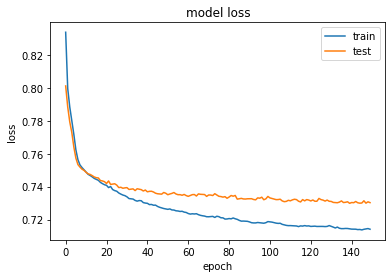

In [34]:
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
# Evaluate Encoded Embeddings 
X_train_enc = encoder.predict(<input>)